In [2]:
import sys
sys.path.append('../Quality/')

import pickle
import numpy as np
from skimage import io
from tqdm import tqdm
from skimage.measure import label
from matplotlib import pyplot as plt
from Quality import compute_overlap_array

In [3]:
def load_file(filepath):
    return np.array(io.imread(filepath)).astype(np.uint8)

In [4]:
collman_15_annot = np.stack(pickle.load(open('./data/collman_15_label_full.pkl', 'rb'))).astype(int)
collman_14_annot = np.stack(pickle.load(open('./data/collman_14_label.pkl', 'rb'))).astype(int)

In [5]:
print(collman_15_annot.shape)
print(collman_14_annot.shape)

(21, 125, 175)
(20, 331, 409)


In [7]:
NOMADS_collman_15 = load_file('./results/Collman_15_full_results.tiff')
print(NOMADS_collman_15.shape)
NOMADS_collman_14 = load_file('./results/NOMADS_collman_14_results.tiff')
print(NOMADS_collman_14.shape)

(21, 125, 175)
(20, 331, 409)


In [6]:
PLOS_collman_15 = pickle.load(open('./results/PLOS_collman_15.pkl', 'rb'))
PLOS_ordered_predictions_15 = np.swapaxes(PLOS_collman_15, 0, 2)
PLOS_ordered_predictions_15 = np.swapaxes(PLOS_ordered_predictions_15, 1, 2)
print(PLOS_ordered_predictions_15.shape)

PLOS_collman_14 = pickle.load(open('./results/PLOS_collman_14.pkl', 'rb'))
PLOS_ordered_predictions_14 = np.swapaxes(PLOS_collman_14, 0, 2)
PLOS_ordered_predictions_14 = np.swapaxes(PLOS_ordered_predictions_14, 1, 2)
print(PLOS_ordered_predictions_14.shape)

(19, 125, 175)
(20, 331, 409)


In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [8]:
NOMADS_15_overlap = compute_overlap_array(NOMADS_collman_15, collman_15_annot)
NOMADS_14_overlap = compute_overlap_array(NOMADS_collman_14, collman_14_annot)

In [9]:
def make_roc(volume, gt):
    prec_list = []
    rec_list = []
    f1_list = []
    thresh_list = []
    for i in tqdm(np.linspace(0., 1., 20)):
        true_vol = volume > i
        predictions = label(true_vol)
        overlap = compute_overlap_array(predictions, gt)
        out = compare(overlap, overlap, 'ROC', 'NONE', 'NA', False)[0]
        tp = out[0]
        fp = out[1]
        fn = out[2]
        
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1 = 2*(prec*rec)/(prec+rec)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        thresh_list.append(i)
        
    return prec_list, rec_list, f1_list, thresh_list

In [13]:
def compare(overlap_1, overlap_2, overlap_1_name, overlap_2_name, dataset_name, do_fig = True):
    arr = np.array(overlap_1['gtPerPrediction'])
    n_tp = np.sum([arr >= 1])
    n_fp = np.sum([arr == 0])
    arr = np.array(overlap_1['predictionPerGt'])
    n_fn = np.sum(np.ones_like(arr)) - n_tp

    arr = np.array(overlap_2['gtPerPrediction'])
    m_tp = np.sum([arr >= 1])
    m_fp = np.sum([arr == 0])
    arr = np.array(overlap_2['predictionPerGt'])
    m_fn = np.sum(np.ones_like(arr)) - m_tp

    if do_fig:
        plt.figure(figsize=(16, 10))
        plt.suptitle('Algorithm Performance on '+dataset_name)
        ax = plt.subplot(221)
        ax.set_xlabel('#of Predictions Per Synapse')
        ax.set_ylabel('# of Occurrences')

        arr = np.array(overlap_1['predictionPerGt'])

        freq = [np.sum([arr == 0]),
                np.sum([arr == 1]),
                np.sum([arr >= 2])]

        r1 = ax.bar([-.25, .75, 1.75], freq, .25)

        arr = np.array(overlap_2['predictionPerGt'])

        freq = [np.sum([arr == 0]),
                np.sum([arr == 1]),
                np.sum([arr >= 2])]

        r2 = ax.bar([0, 1, 2], freq, .25)



        ax.set_xticklabels(('','0', '', '1', '', '2+'))
        ax.legend((r1, r2), (overlap_1_name, overlap_2_name), loc='lower center', bbox_to_anchor=(1.7, -.9))



        ax = plt.subplot(222)
        ax.set_xlabel('# of Synapses Per Prediction')
        ax.set_ylabel('# of Occurrences')

        arr = np.array(overlap_1['gtPerPrediction'])

        freq = [np.sum([arr == 0]),
                np.sum([arr == 1]),
                np.sum([arr >= 2])]


        r1 = ax.bar([-.25, .75, 1.75], freq, .25)

        arr = np.array(overlap_2['gtPerPrediction'])

        freq = [np.sum([arr == 0]),
                np.sum([arr == 1]),
                np.sum([arr >= 2])]


        r2 = ax.bar([0, 1, 2], freq, .25)


        ax.set_xticklabels(('','0', '', '1', '', '2+'))

        ax = plt.subplot(223)
        ax.set_ylabel('# of Occurrences')

        ax.set_xticklabels(('','True\nPositive', '',  'False\nPositive', '', 'False\nNegative'))
        r1 = ax.bar([-.25, .75, 1.75], [n_tp, n_fp, n_fn], .25)
        r2 = ax.bar([0, 1, 2], [m_tp, m_fp, m_fn], .25)
        plt.show()
    return [[n_tp, n_fp, n_fn], [m_tp, m_fp, m_fn]]


In [11]:
prec_15, rec_15, f1_15, thresh_15 = make_roc(PLOS_ordered_predictions_15, collman_15_annot)
prec_14, rec_14, f1_14, thresh_14 = make_roc(PLOS_ordered_predictions_14, collman_14_annot)

 95%|█████████▌| 19/20 [00:02<00:00,  8.52it/s]/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


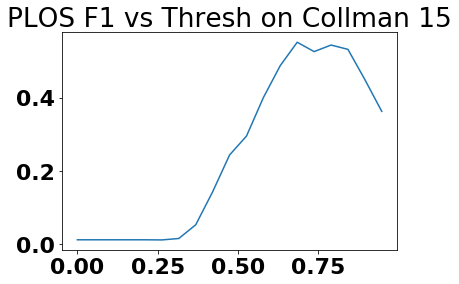

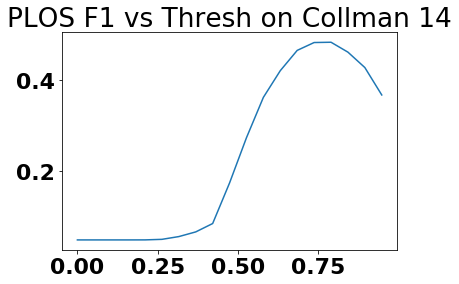

In [12]:
plt.figure()
plt.title('PLOS F1 vs Thresh on Collman 15')
plt.plot(thresh_15, f1_15)
plt.show()


plt.figure()
plt.title('PLOS F1 vs Thresh on Collman 14')
plt.plot(thresh_14, f1_14)
plt.show()

In [13]:
print(thresh_15[np.argmax(f1_15[:-1])])
print(thresh_14[np.argmax(f1_14[:-1])])

0.684210526316
0.789473684211


In [14]:
PLOS_15_overlap = compute_overlap_array(PLOS_ordered_predictions_15 > .68, collman_15_annot)
PLOS_14_overlap = compute_overlap_array(PLOS_ordered_predictions_14 > .78, collman_14_annot)

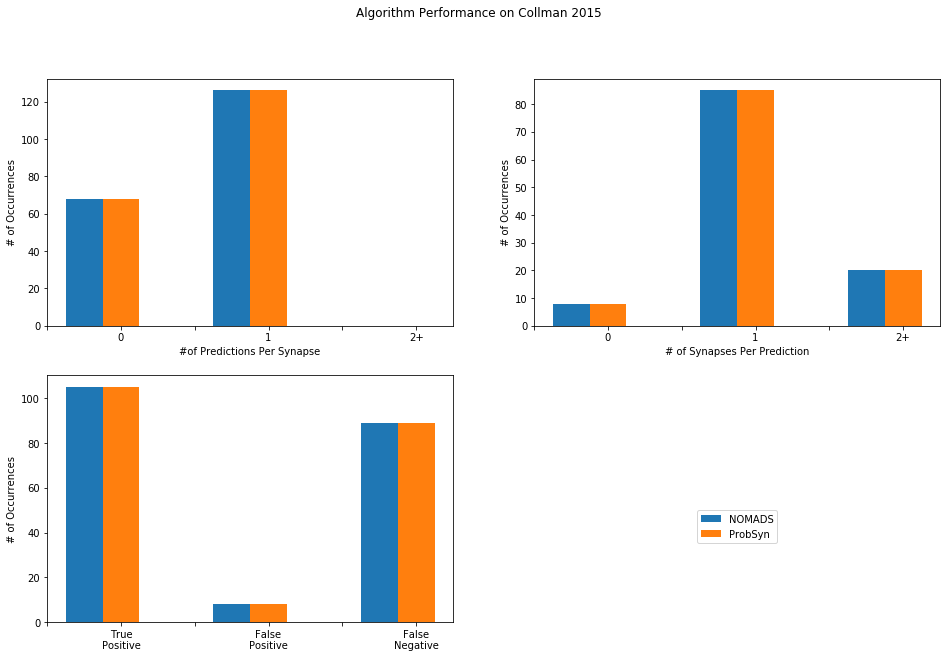

In [14]:
nomads15, probsyn15 = compare(NOMADS_15_overlap, NOMADS_15_overlap, 'NOMADS', 'ProbSyn', 'Collman 2015', do_fig = True)

In [15]:
def get_prec_rec_f1(stats):
    tp = stats[0]
    fp = stats[1]
    fn = stats[2]
    
    prec = tp / (tp + fp)
    rec = tp/(tp + fn)
    f1 = 2 * prec * rec /(prec + rec)
    return prec, rec, f1

In [16]:
print(get_prec_rec_f1(nomads15))

(0.92920353982300885, 0.54123711340206182, 0.68403908794788282)


In [18]:
print(get_prec_rec_f1(probsyn15))

(0.50490196078431371, 0.59883720930232553, 0.5478723404255319)


/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


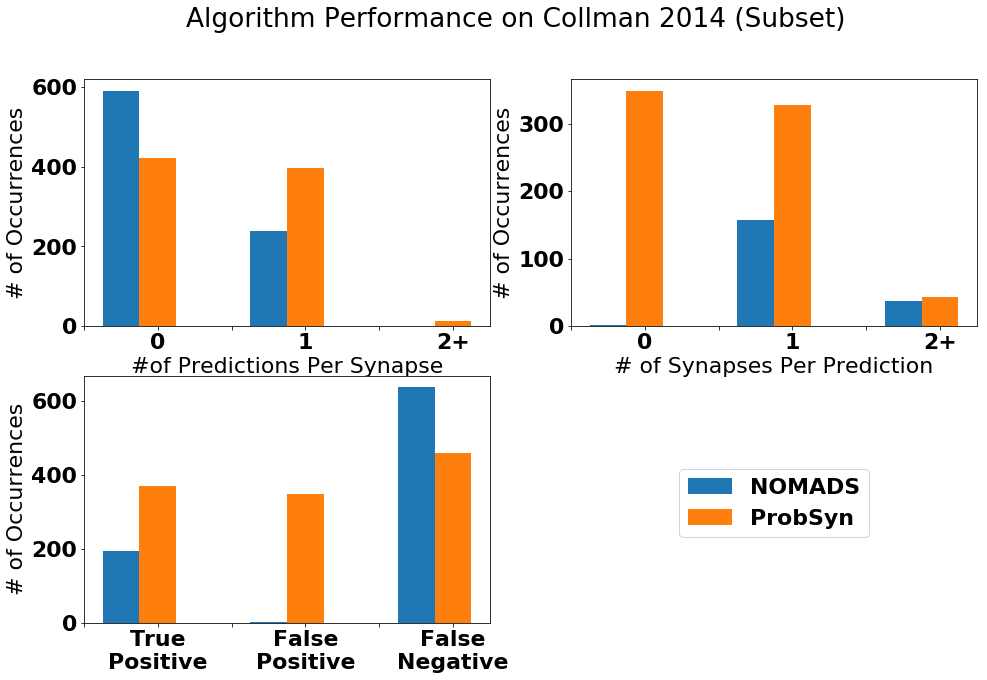

In [19]:
nomads14, probsyn14 = compare(NOMADS_14_overlap, PLOS_14_overlap, 'NOMADS', 'ProbSyn', 'Collman 2014 (Subset)', do_fig = True)

In [20]:
print(get_prec_rec_f1(nomads14))

(0.98979591836734693, 0.23345367027677497, 0.37779941577409931)


In [21]:
print(get_prec_rec_f1(probsyn14))

(0.51527777777777772, 0.44645006016847172, 0.4784010315925209)
